# Предсказание расхода извести

Решение обратной задачи: оптимизация расхода извести с оценкой потенциальной возможной экономии на исторических данных.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")


from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import *

from catboost import CatBoostRegressor, CatBoostClassifier

## Загрузка и подготовка данных

In [2]:
df = pd.read_csv('clean_data.csv', index_col=0)
df.head()

,МАРКА,t вып-обр,t под током,t продувка,ПСН гр.,чист расход C,чист расход Cr,чист расход Mn,чист расход Si,чист расход V,...,химшлак первый MnO_1,химшлак первый R_1,химшлак первый SiO2_1,химшлак последний Al2O3,химшлак последний CaO,химшлак последний FeO,химшлак последний MgO,химшлак последний MnO,химшлак последний R,химшлак последний SiO2
589,Э76ХФ,18.0,20.016667,41.850000,2.431057,0.339285,0.075060,0.066049,0.068946,0.038742,...,0.23,2.3,25.6,3.2,54.8,0.8,6.1,0.09,2.4,23.2
818,Э90ХАФ,7.0,17.383333,41.033333,3.004480,0.523411,0.108273,0.200457,0.148846,0.095573,...,0.11,2.4,24.5,4.6,61.8,0.5,6.1,0.08,2.4,26.1
1029,Другие,9.0,18.950000,43.850000,2.643735,0.433960,0.121086,0.175658,0.089606,0.041396,...,0.18,2.4,20.4,4.7,54.8,0.6,11.6,0.16,2.1,26.1
1036,Другие,7.0,19.216667,46.716667,3.000000,0.548870,0.121086,0.199137,0.087354,0.041748,...,0.25,2.3,23.8,5.4,51.9,0.5,10.3,0.15,2.1,24.2
1345,Э76ХФ,26.0,19.883333,42.050000,3.775293,0.402655,0.168487,0.176548,0.153988,0.041933,...,0.19,2.2,22.4,5.2,54.5,0.3,14.0,0.14,2.1,26.6


In [3]:
df.shape

(4576, 67)

In [4]:
target = 'сыпуч известь РП'

<AxesSubplot:>

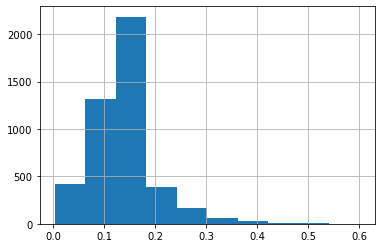

In [5]:
(df[target]).hist()

In [6]:
df[target].value_counts().index.unique()

Float64Index([               0.126, 0.052000000000000005,                0.063,
               0.07400000000000001,                0.086,                0.064,
                              0.08,                0.053,                0.079,
               0.14800000000000002,
              ...
                             0.038,                0.255,                0.388,
               0.35100000000000003,                  0.6,                 0.41,
                             0.384,                0.364,                0.509,
                             0.307],
             dtype='float64', length=379)

In [7]:
X = df.drop(target, axis=1)
X.shape

(4576, 66)

In [8]:
X = pd.get_dummies(X) # one-hot encoding для марки стали

In [9]:
# Нормализация данных
scaler_X = StandardScaler()
X = scaler_X.fit_transform(X)

In [10]:
def test_model(model, X, y):
    error = -cross_val_score(model, X, y, scoring='neg_mean_absolute_percentage_error', cv=5).mean()
    return error

In [11]:
def test_many_models(models, df, X, target):
    for model in models:
        print(model)
        y = df[target]
        error = test_model(model, X, y)
        print(f'Средняя ошибка модели: {error*100:.2f}%\n')
        return 

In [12]:
models = [LinearRegression(), Lasso(), Ridge(), RandomForestRegressor(), CatBoostRegressor(loss_function='MAPE', n_estimators=1000, silent=True)]

In [13]:
test_many_models(models, df, X, target)

LinearRegression()
Средняя ошибка модели: 43.42%



Решение данной задачи с помощью регрессии даёт очень низкую точность. Попробуем решить с помощью классификации.

## Классификация

Для классификации необходимо вещественную целевую переменную превратить в категориальную. Для этого попробуем её на интервалы

In [14]:
df[target].value_counts()

0.126    999
0.052     78
0.063     68
0.074     67
0.086     65
        ... 
0.410      1
0.384      1
0.364      1
0.509      1
0.307      1
Name: сыпуч известь РП, Length: 379, dtype: int64

In [15]:
def catcovert(df, target, q):
    cat_target = pd.qcut(df[target], q)
    print(cat_target.value_counts())
    mask = {cat:i for i,cat in enumerate(cat_target.unique())}
    cat_target = cat_target.replace(mask)
    print(cat_target.value_counts())
    return cat_target

In [16]:
catcovert(df, target, 2);

(0.002, 0.126]    2813
(0.126, 0.6]      1763
Name: сыпуч известь РП, dtype: int64
0    2813
1    1763
Name: сыпуч известь РП, dtype: int64


In [17]:
catcovert(df, target, 3);

(0.002, 0.106]    1545
(0.136, 0.6]      1520
(0.106, 0.136]    1511
Name: сыпуч известь РП, dtype: int64
1    1545
2    1520
0    1511
Name: сыпуч известь РП, dtype: int64


In [18]:
catcovert(df, target, 4);

(0.086, 0.126]    1640
(0.002, 0.086]    1173
(0.151, 0.6]      1127
(0.126, 0.151]     636
Name: сыпуч известь РП, dtype: int64
0    1640
2    1173
1    1127
3     636
Name: сыпуч известь РП, dtype: int64


Разбиение на 3 интервала даёт наиболее сбалансированное распределение классов

In [40]:
def test_model(model, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    y_pred = model.fit(X_train, y_train).predict(X_test)
    print(classification_report(y_test, y_pred))
    print(f'Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred, adjusted=True):.2f}')

Протестируем 3 модели:
* Логистическая регрессия (LogisticRegression)
* Случайный лес (RandomForestClassifier)
* Бустинг (CatBoostClassifier)

In [41]:
test_model(LogisticRegression(n_jobs=-1, random_state=42, multi_class='multinomial'), X, catcovert(df, target, 3))

(0.002, 0.106]    1545
(0.136, 0.6]      1520
(0.106, 0.136]    1511
Name: сыпуч известь РП, dtype: int64
1    1545
2    1520
0    1511
Name: сыпуч известь РП, dtype: int64
              precision    recall  f1-score   support

           0       0.54      0.52      0.53       402
           1       0.44      0.42      0.43       378
           2       0.68      0.74      0.70       364

    accuracy                           0.56      1144
   macro avg       0.55      0.56      0.56      1144
weighted avg       0.55      0.56      0.55      1144

Balanced Accuracy: 0.34


In [42]:
test_model(RandomForestClassifier(), X, catcovert(df, target, 3))

(0.002, 0.106]    1545
(0.136, 0.6]      1520
(0.106, 0.136]    1511
Name: сыпуч известь РП, dtype: int64
1    1545
2    1520
0    1511
Name: сыпуч известь РП, dtype: int64
              precision    recall  f1-score   support

           0       0.56      0.52      0.54       402
           1       0.45      0.46      0.46       378
           2       0.65      0.70      0.67       364

    accuracy                           0.56      1144
   macro avg       0.56      0.56      0.56      1144
weighted avg       0.56      0.56      0.56      1144

Balanced Accuracy: 0.34


In [43]:
test_model(CatBoostClassifier(silent=True), X, catcovert(df, target, 3))

(0.002, 0.106]    1545
(0.136, 0.6]      1520
(0.106, 0.136]    1511
Name: сыпуч известь РП, dtype: int64
1    1545
2    1520
0    1511
Name: сыпуч известь РП, dtype: int64
              precision    recall  f1-score   support

           0       0.53      0.50      0.52       402
           1       0.46      0.43      0.45       378
           2       0.66      0.74      0.70       364

    accuracy                           0.56      1144
   macro avg       0.55      0.56      0.55      1144
weighted avg       0.55      0.56      0.55      1144

Balanced Accuracy: 0.34


## Выводы
* Регрессия не работает. Классификация рулит.
* Бустинг дал наилучшие метрики. 
* В среднем точность составляет 56%.
* F1-score для различных интервалов составляет от 0.45 до 0.7
* Сбалансированная точность 34 %. То есть мы на 34 процента угадываем лучше чем рандом.